In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

DATA_RAW = Path("../data/01_raw")  # ajusta si tu ruta es distinta


In [4]:
results = pd.read_csv(DATA_RAW / "results.csv")
races = pd.read_csv(DATA_RAW / "races.csv")

# opcional si ya lo tienes
qualifying_path = DATA_RAW / "qualifying.csv"
qualifying = pd.read_csv(qualifying_path) if qualifying_path.exists() else None

results.shape, races.shape, (None if qualifying is None else qualifying.shape)


((26759, 18), (1125, 18), (10494, 9))

In [5]:
def build_driver_season_dataset(results: pd.DataFrame, races: pd.DataFrame, qualifying: pd.DataFrame | None = None) -> pd.DataFrame:
    races_sel = races[["raceId", "year", "round", "circuitId"]].copy()
    df = results.merge(races_sel, on="raceId", how="left")

    num_cols = ["raceId","driverId","constructorId","grid","points","positionOrder","statusId","laps","milliseconds","year","round","circuitId"]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Flags
    df["is_finish"] = (df["statusId"] == 1).astype(int)  # ajusta si tu finished_id es otro
    df["is_podium"] = (df["positionOrder"] <= 3).astype(int)
    df["is_win"] = (df["positionOrder"] == 1).astype(int)

    # Pace (solo finishers + sanity filters)
    df["pace_ms_lap"] = np.nan
    m = df["is_finish"].eq(1) & df["milliseconds"].between(600_000, 20_000_000) & df["laps"].between(10, 100)
    df.loc[m, "pace_ms_lap"] = df.loc[m, "milliseconds"] / df.loc[m, "laps"]

    g = df.groupby(["driverId", "year"], as_index=False)
    agg = g.agg(
        n_races=("raceId","nunique"),
        n_finish=("is_finish","sum"),
        finish_rate=("is_finish","mean"),
        podium_rate=("is_podium","mean"),
        win_rate=("is_win","mean"),
        points_sum=("points","sum"),
        points_avg=("points","mean"),
        grid_avg=("grid","mean"),
        grid_median=("grid","median"),
        pace_avg=("pace_ms_lap","mean"),
        pace_median=("pace_ms_lap","median"),
        constructor_mode=("constructorId", lambda s: s.mode().iloc[0] if len(s.mode()) else np.nan),
    )

    if qualifying is not None and {"raceId","driverId","position"}.issubset(qualifying.columns):
        q = qualifying.copy()
        for c in ["raceId","driverId","position"]:
            q[c] = pd.to_numeric(q[c], errors="coerce")
        q = q.merge(races_sel, on="raceId", how="left")

        qg = q.groupby(["driverId","year"], as_index=False).agg(
            quali_pos_avg=("position","mean"),
            quali_pos_median=("position","median"),
        )
        agg = agg.merge(qg, on=["driverId","year"], how="left")

    # filtra temporadas con muy pocas carreras
    agg = agg[agg["n_races"] >= 5].copy()
    return agg


In [6]:
driver_season = build_driver_season_dataset(results, races, qualifying)
driver_season.head(), driver_season.shape


(   driverId  year  n_races  n_finish  finish_rate  podium_rate  win_rate  \
 0         1  2007       17        14     0.823529     0.705882  0.235294   
 1         1  2008       18        16     0.888889     0.555556  0.277778   
 2         1  2009       17         9     0.529412     0.294118  0.117647   
 3         1  2010       19        15     0.789474     0.473684  0.157895   
 4         1  2011       19        16     0.842105     0.315789  0.157895   
 
    points_sum  points_avg  grid_avg  grid_median       pace_avg  \
 0       109.0    6.411765  2.588235          2.0   89642.334106   
 1        98.0    5.444444  3.888889          2.5   94051.869825   
 2        49.0    2.882353  9.176471          9.0  103588.579810   
 3       240.0   12.631579  5.157895          4.0  104714.576901   
 4       227.0   11.947368  3.578947          3.0  100235.479313   
 
      pace_median  constructor_mode  quali_pos_avg  quali_pos_median  
 0   88938.628660                 1       2.647059     

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def make_X_for_clustering(df_driver_season: pd.DataFrame):
    df = df_driver_season.copy()

    id_cols = ["driverId", "year"]
    feature_cols = [c for c in df.columns if c not in id_cols]

    X = df[feature_cols].copy()
    # elimina no numéricas si quedaran
    for c in list(X.columns):
        if X[c].dtype == "object":
            X = X.drop(columns=[c])

    preprocess = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    X_scaled = preprocess.fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X_scaled)

    meta = {
        "id_df": df[id_cols].reset_index(drop=True),
        "feature_cols": list(X.columns),
        "preprocess": preprocess,
        "pca": pca,
        "pca_explained_var": pca.explained_variance_ratio_,
    }
    return X_scaled, X_2d, meta


In [8]:
X_scaled, X_2d, meta = make_X_for_clustering(driver_season)
meta["pca_explained_var"], X_scaled.shape, X_2d.shape


(array([0.4791062 , 0.16048987]), (1756, 14), (1756, 2))

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_k_range(X, k_min=2, k_max=12, random_state=42):
    rows = []

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        rows.append({
            "model": "kmeans",
            "k": k,
            "inertia": float(km.inertia_),
            "silhouette": float(silhouette_score(X, labels)),
            "davies_bouldin": float(davies_bouldin_score(X, labels)),
            "calinski_harabasz": float(calinski_harabasz_score(X, labels)),
        })

    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
        labels = gmm.fit_predict(X)
        rows.append({
            "model": "gmm",
            "k": k,
            "bic": float(gmm.bic(X)),
            "aic": float(gmm.aic(X)),
            "silhouette": float(silhouette_score(X, labels)),
            "davies_bouldin": float(davies_bouldin_score(X, labels)),
            "calinski_harabasz": float(calinski_harabasz_score(X, labels)),
        })

    for k in range(k_min, k_max + 1):
        ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = ag.fit_predict(X)
        rows.append({
            "model": "agglomerative_ward",
            "k": k,
            "silhouette": float(silhouette_score(X, labels)),
            "davies_bouldin": float(davies_bouldin_score(X, labels)),
            "calinski_harabasz": float(calinski_harabasz_score(X, labels)),
        })

    return pd.DataFrame(rows)


In [10]:
scores = evaluate_k_range(X_scaled, k_min=2, k_max=12, random_state=42)
scores.head()


,model,k,inertia,silhouette,davies_bouldin,calinski_harabasz,bic,aic
0,kmeans,2,16747.238438,0.379198,1.184901,820.772919,NaN,NaN
1,kmeans,3,13963.827921,0.403069,1.037128,666.620992,NaN,NaN
2,kmeans,4,11584.881547,0.255671,1.243129,655.292430,NaN,NaN
3,kmeans,5,10089.908762,0.274212,1.185963,628.825155,NaN,NaN
4,kmeans,6,9020.553182,0.271199,1.189003,603.866113,NaN,NaN


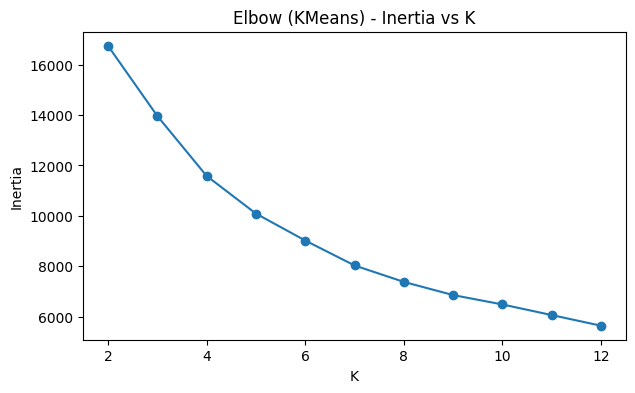

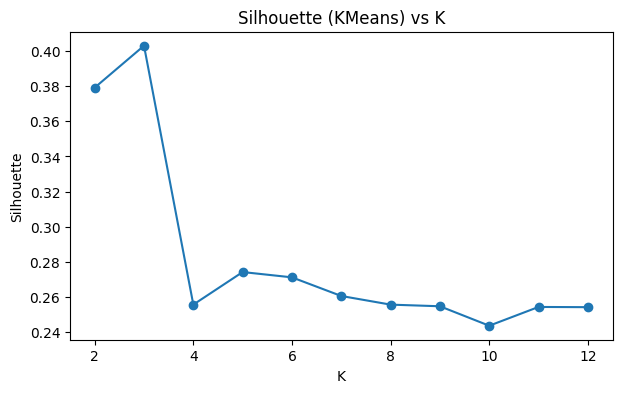

In [11]:
kmeans_scores = scores[scores["model"]=="kmeans"].sort_values("k")

plt.figure(figsize=(7,4))
plt.plot(kmeans_scores["k"], kmeans_scores["inertia"], marker="o")
plt.title("Elbow (KMeans) - Inertia vs K")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(kmeans_scores["k"], kmeans_scores["silhouette"], marker="o")
plt.title("Silhouette (KMeans) vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()


In [12]:
best_row = kmeans_scores.sort_values(["silhouette"], ascending=False).iloc[0]
best_k = int(best_row["k"])
best_k, best_row.to_dict()


(3,
 {'model': 'kmeans',
  'k': 3,
  'inertia': 13963.827920755768,
  'silhouette': 0.4030693285983894,
  'davies_bouldin': 1.0371277643750267,
  'calinski_harabasz': 666.6209924874062,
  'bic': nan,
  'aic': nan})

In [13]:
km_final = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = km_final.fit_predict(X_scaled)

driver_season_labeled = driver_season[["driverId","year"]].copy()
driver_season_labeled["cluster"] = labels
driver_season_labeled.head()


,driverId,year,cluster
0,1,2007,1
1,1,2008,1
2,1,2009,1
3,1,2010,1
4,1,2011,1


In [14]:
dfp = driver_season.copy()
dfp["cluster"] = labels

num_cols = [c for c in dfp.columns if c not in ["driverId","year","cluster"] and pd.api.types.is_numeric_dtype(dfp[c])]

cluster_profile_mean = dfp.groupby("cluster")[num_cols].mean().round(3)
cluster_sizes = dfp.groupby("cluster").size().rename("n_samples")

cluster_sizes, cluster_profile_mean


(cluster
 0    1271
 1     407
 2      78
 Name: n_samples, dtype: int64,
          n_races  n_finish  finish_rate  podium_rate  win_rate  points_sum  \
 cluster                                                                      
 0         13.367     2.138        0.139        0.040     0.006       7.850   
 1         16.408    11.275        0.667        0.407     0.162     102.491   
 2          9.038     1.782        0.214        0.136     0.030       9.295   
 
          points_avg  grid_avg  grid_median    pace_avg  pace_median  \
 cluster                                                               
 0             0.546    12.829       12.986  110114.538   104074.217   
 1             5.778     5.242        4.469  110357.215    99136.512   
 2             1.112    10.434       10.391  403495.112   396402.427   
 
          constructor_mode  quali_pos_avg  quali_pos_median  
 cluster                                                     
 0                  54.773         14.691  

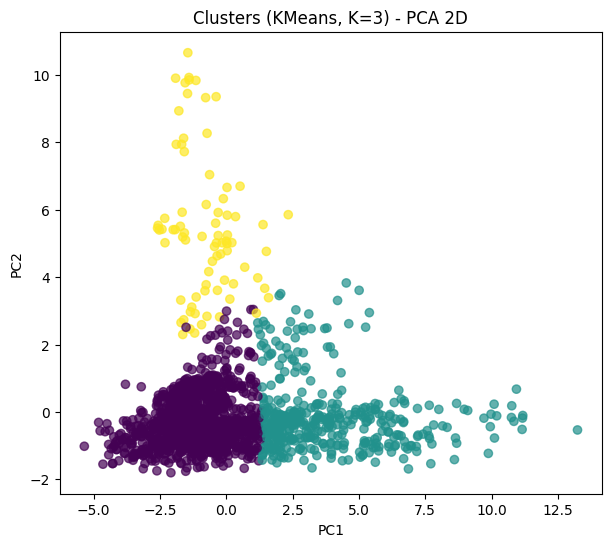

In [15]:
plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, alpha=0.7)
plt.title(f"Clusters (KMeans, K={best_k}) - PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
